In [1]:
import pandas as pd
import numpy as np
from datasets import load_from_disk


In [2]:
combined_data = load_from_disk("data/processed/combined_data")
labels = combined_data["train"].features["label"].names


In [3]:
print(combined_data)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 59600
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 7450
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7450
    })
})


In [4]:
import torch
from transformers import AutoTokenizer

model_id = "answerdotai/ModernBERT-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


In [5]:
combined_data_encoded = combined_data.map(tokenize, batched=True, batch_size=None)


Map:   0%|          | 0/7450 [00:00<?, ? examples/s]

In [6]:
X_train = np.array(combined_data_encoded["train"]["text"])
X_valid = np.array(combined_data_encoded["validation"]["text"])
y_train = np.array(combined_data_encoded["train"]["label"])
y_valid = np.array(combined_data_encoded["validation"]["label"])
X_train.shape, X_valid.shape


((59600,), (7450,))

In [7]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_id, num_labels=num_labels)
        .to(device))


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [9]:
from huggingface_hub import notebook_login
notebook_login()


In [10]:
from transformers import Trainer, TrainingArguments

batch_size = 32
num_train_epochs = 10
learning_rate = 5e-5
logging_steps = 100
model_name = f"{model_id}-finetuned-arxiv"

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=16,
                                  weight_decay=0.01,
                                  bf16=True,
                                  optim="adamw_torch_fused",
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")


In [11]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
train_labels = np.array(combined_data_encoded["train"]["label"])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to PyTorch tensor and move to the right device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_weighted_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Apply class weights to the loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss


In [12]:
from transformers import Trainer
trainer = CustomTrainer(
    class_weights=class_weights,
    model=model, 
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=combined_data_encoded["train"],
    eval_dataset=combined_data_encoded["validation"],
    tokenizer=tokenizer
)

trainer.train()


/tmp/ipykernel_40927/3240257685.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.468200,0.442573,0.846174,0.839328
2,0.273900,0.482815,0.853826,0.846385
3,0.139900,0.700720,0.842148,0.839893
4,0.053300,0.950362,0.847248,0.844089
5,0.007000,1.305782,0.839195,0.837149
6,0.009700,1.471184,0.841074,0.839492
7,0.004400,1.535128,0.842148,0.843600
8,0.000400,1.593069,0.849933,0.845929
9,0.000000,1.633168,0.846980,0.844152
10,0.000000,1.617867,0.850067,0.847365


TrainOutput(global_step=18630, training_loss=0.10431551086349923, metrics={'train_runtime': 10565.6451, 'train_samples_per_second': 56.409, 'train_steps_per_second': 1.763, 'total_flos': 2.9594784512352e+17, 'train_loss': 0.10431551086349923, 'epoch': 10.0})

In [32]:
preds_output = trainer.predict(combined_data_encoded["test"])


In [38]:
preds_output.metrics


{'test_loss': 1.518555760383606,
 'test_accuracy': 0.8551677852348993,
 'test_f1': 0.8534089838413074,
 'test_runtime': 53.4801,
 'test_samples_per_second': 139.304,
 'test_steps_per_second': 8.714}

In [39]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = np.array(combined_data_encoded["test"]["label"])


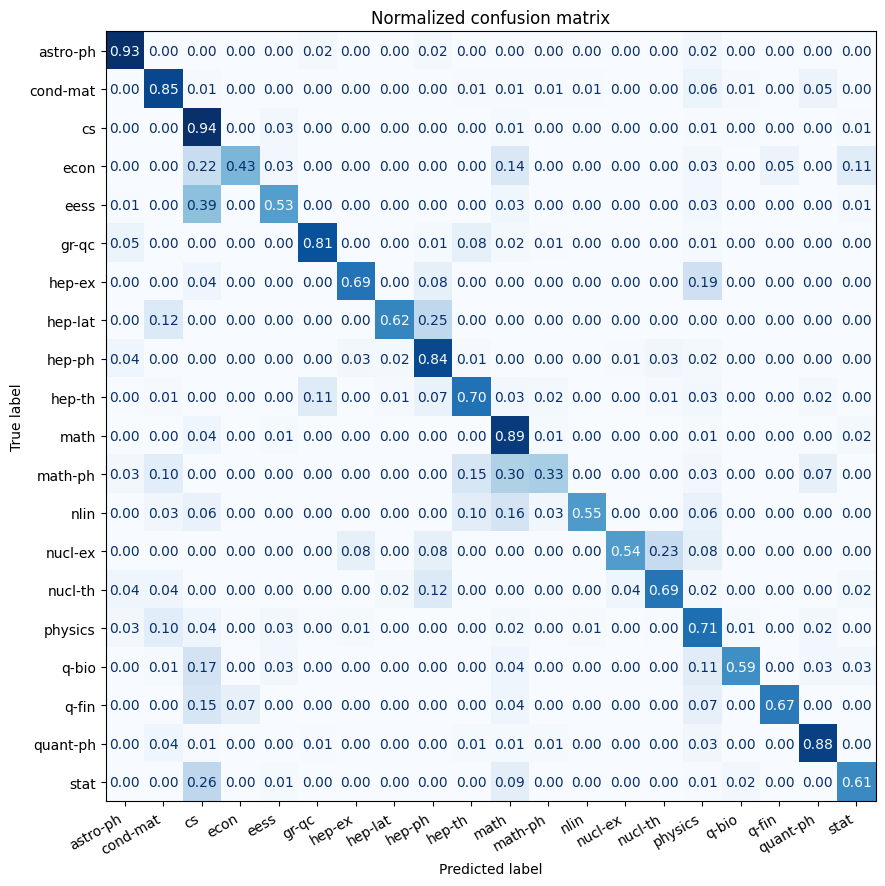

In [40]:
from src.utils import plot_confusion_matrix

plot_confusion_matrix(y_preds, y_test, labels)


In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}


In [ ]:
# Convert our dataset back to PyTorch tensors
data_encoded.set_format("torch",
                        columns=["input_ids", "attention_mask", "label"])
# Compute loss values
data_encoded["validation"] = data_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)


In [ ]:
def label_int2str(row):
    return data["train"].features["label"].int2str(row)


In [ ]:
data_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = data_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))


In [ ]:
df_test.sort_values("loss", ascending=False).head(10)


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)


In [41]:
trainer.push_to_hub(commit_message="Training completed!")


CommitInfo(commit_url='https://huggingface.co/gpham/ModernBERT-base-finetuned-arxiv/commit/4f638cd2d4ca1454a6312ddc6aa3b414ea7482aa', commit_message='Training completed!', commit_description='', oid='4f638cd2d4ca1454a6312ddc6aa3b414ea7482aa', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gpham/ModernBERT-base-finetuned-arxiv', endpoint='https://huggingface.co', repo_type='model', repo_id='gpham/ModernBERT-base-finetuned-arxiv'), pr_revision=None, pr_num=None)

In [42]:
from transformers import pipeline
model_id = "gpham/ModernBERT-base-finetuned-arxiv"
classifier = pipeline("text-classification", model=model_id)


config.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/598M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [52]:
test_text = combined_data["test"][:10]["text"]
test_label = combined_data["test"][:10]["label"]

In [50]:
preds = classifier(test_text, return_all_scores=False)


/cluster/processing/climate_llm/learn/aa/Advanced-Analytics-03/.venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
/cluster/processing/climate_llm/learn/aa/Advanced-Analytics-03/.venv/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:236: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


In [51]:
preds

[{'label': 'LABEL_0', 'score': 0.7938306927680969},
 {'label': 'LABEL_4', 'score': 0.5276193022727966},
 {'label': 'LABEL_18', 'score': 0.9668517708778381},
 {'label': 'LABEL_0', 'score': 1.0},
 {'label': 'LABEL_5', 'score': 1.0},
 {'label': 'LABEL_2', 'score': 0.837887167930603},
 {'label': 'LABEL_10', 'score': 0.9999997615814209},
 {'label': 'LABEL_9', 'score': 0.9999475479125977},
 {'label': 'LABEL_16', 'score': 0.9999815225601196},
 {'label': 'LABEL_2', 'score': 1.0}]

In [53]:
test_label

[18, 0, 18, 0, 5, 2, 19, 9, 16, 2]